In [2]:
import numpy as np
import strawberryfields as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

GKP_SPACING = np.sqrt(np.pi)

def preprocess_homodyne_data(measurements):
    mean = np.mean(measurements)
    std = np.std(measurements)
    normalized = (measurements - mean) / std

    modular_residual = normalized % GKP_SPACING
    sin_feature = np.sin(2 * np.pi * modular_residual / GKP_SPACING)
    cos_feature = np.cos(2 * np.pi * modular_residual / GKP_SPACING)

    features = np.vstack((normalized, sin_feature, cos_feature)).T
    return features

# Convert GKP dB -> epsilon
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to the corresponding epsilon,
    defined via tanh(epsilon) = 10^(-db_val/10).

    For example:
      db_val=10  => tanh(eps)=0.1   => eps ~ 0.100167
      db_val=15  => tanh(eps)=0.0316 => eps ~ 0.032
    """
    t = 10.0 ** (-db_val / 10.0)  # tanh(epsilon) = t
    # epsilon = arctanh(t) = 0.5 * ln((1+t)/(1-t))
    eps = 0.5 * np.log((1.0 + t)/(1.0 - t))
    return eps

# Prepare GKP + channel => Wigner tomography
def compute_wigner_tomography(
    epsilon: float,
    in_state=(0.0, 0.0),
    eta=1.0,
    gamma=0.0,
    q_pts=50,
    range_q=(-5.0,5.0),
    range_p=(-5.0,5.0),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> np.ndarray:
    """
    Prepare a single-mode GKP(epsilon, in_state), apply pure-loss channel(eta),
    then approximate the dephasing channel by integrating over many rotation angles
    phi ~ Normal(0, gamma). Returns a 2D Wigner array of shape (q_pts, q_pts).
    """
    qvals = np.linspace(range_q[0], range_q[1], q_pts)
    pvals = np.linspace(range_p[0], range_p[1], q_pts)

    # If gamma is extremely small, skip the rotation sampling
    if gamma < 1e-12:
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
        eng = sf.Engine(backend)
        state = eng.run(prog).state
        return state.wigner(0, qvals, pvals)

    # Otherwise, discretize phi in ± phi_clip * sqrt(gamma)
    phi_std = np.sqrt(gamma)
    phi_min = -phi_clip * phi_std
    phi_max = +phi_clip * phi_std
    phis = np.linspace(phi_min, phi_max, Nphi)
    dphi = phis[1] - phis[0]  # step size

    # Gaussian weights
    w_phi = np.exp(-0.5 * (phis/phi_std)**2)
    w_phi /= (phi_std * np.sqrt(2*np.pi))  # normalization

    W_accum = np.zeros((q_pts, q_pts), dtype=float)
    for i, phi_val in enumerate(phis):
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]

        eng_phi = sf.Engine(backend)
        state_phi = eng_phi.run(prog_phi).state
        W_phi = state_phi.wigner(0, qvals, pvals)

        W_accum += w_phi[i]*W_phi

    # Multiply by dphi to approximate integral
    return W_accum * dphi

# Dataset: random (eta, gamma, dB) => flattened Wigner + epsilon
class GKPChannelDatasetWithEps(Dataset):
    """
    Samples random (eta, gamma, dB) in given ranges,
    simulates the Wigner function for GKP(epsilon) with that dB => epsilon.
    The final input X is shape (q_pts^2 + 1), i.e. [W_flat, epsilon].
    The label Y is shape (2), i.e. [eta, gamma].
    """
    def __init__(
        self,
        N: int,
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1.0),
        db_range=(10.0, 15.0),
        q_pts=50,
        range_q=(-5.0,5.0),
        range_p=(-5.0,5.0),
        in_state=(0.0, 0.0),
        backend="bosonic",
        Nphi=5,
        phi_clip=3.0
    ):
        super().__init__()
        self.N = N

        x_list = []
        y_list = []

        # Randomly sample the channel + GKP parameters
        etas    = np.random.uniform(eta_range[0],   eta_range[1],   N)
        gammas  = np.random.uniform(gamma_range[0], gamma_range[1], N)
        db_vals = np.random.uniform(db_range[0],    db_range[1],    N)

        # Generate each training sample
        for i in range(N):
            eps_val = db_to_epsilon(db_vals[i])
            W = compute_wigner_tomography(
                epsilon=eps_val,
                in_state=in_state,
                eta=etas[i],
                gamma=gammas[i],
                q_pts=q_pts,
                range_q=range_q,
                range_p=range_p,
                backend=backend,
                Nphi=Nphi,
                phi_clip=phi_clip
            )

            # Flatten Wigner => shape (q_pts^2,)
            W_flat = W.flatten().astype(np.float32)
            # We'll store X = [W_flat, eps_val]
            x_vector = np.concatenate([W_flat, [eps_val]], axis=0).astype(np.float32)
            # Y = [eta, gamma]
            y_vector = np.array([etas[i], gammas[i]], dtype=np.float32)

            x_list.append(x_vector)
            y_list.append(y_vector)

        self.x_data = np.array(x_list, dtype=np.float32)  # shape (N, q_pts^2 + 1)
        self.y_data = np.array(y_list, dtype=np.float32)  # shape (N, 2)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# 4) Neural Net: (q_pts^2 + 1) => [eta, gamma]
class SimpleRegressor(nn.Module):
    """
    Maps [flattened Wigner, epsilon] => [eta, gamma].
    """
    def __init__(self, input_dim: int, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # final => [eta, gamma]
        )

    def forward(self, x):
        return self.net(x)

# 5) Training: Create dataset, train model
def train_model_with_eps(
    N_train=5000,
    N_test=500,
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6),
    eta_range=(0.5, 1.0),
    gamma_range=(0.0, 1.0),
    db_range=(10.0, 15.0),
    n_epochs=30,
    batch_size=32,
    lr=1e-3,
    hidden_dim=128,
    Nphi=5,
    phi_clip=3.0
):
    """
    Build dataset with random (eta, gamma, dB),
    train the model, return (model, train_losses, test_losses).
    """
    # Create datasets
    train_dataset = GKPChannelDatasetWithEps(
        N=N_train,
        eta_range=eta_range,
        gamma_range=gamma_range,
        db_range=db_range,
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        backend="bosonic",
        Nphi=Nphi,
        phi_clip=phi_clip
    )
    test_dataset = GKPChannelDatasetWithEps(
        N=N_test,
        eta_range=eta_range,
        gamma_range=gamma_range,
        db_range=db_range,
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        backend="bosonic",
        Nphi=Nphi,
        phi_clip=phi_clip
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # Build model
    input_dim = q_pts*q_pts + 1  # Flattened Wigner + 1 scalar epsilon
    model = SimpleRegressor(input_dim=input_dim, hidden_dim=hidden_dim)

    # Loss & Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train
    train_losses = []
    test_losses  = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)

        # Evaluate
        model.eval()
        test_loss_val = 0.0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                preds = model(x_batch)
                loss_val = criterion(preds, y_batch)
                test_loss_val += loss_val.item() * x_batch.size(0)
        epoch_test_loss = test_loss_val / len(test_loader.dataset)

        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch+1}/{n_epochs}: "
              f"train MSE={epoch_train_loss:.6f}, test MSE={epoch_test_loss:.6f}")

    return model, train_losses, test_losses


# 6) Plot training performance

def plot_training_performance(train_losses, test_losses):
    """
    Plots the training vs. test MSE across epochs.
    """
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Model Training Performance")
    plt.legend()
    plt.grid(True)
    plt.show()


# 7) Single-example prediction using variable dB

def predict_single_example_with_eps(
    model: nn.Module,
    eta_true: float,
    gamma_true: float,
    db_val: float,
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6),
    Nphi=5,
    phi_clip=3.0
):
    """
    Generate one Wigner tomography for (eta_true, gamma_true, db_val => epsilon),
    flatten + append epsilon, feed to model, return predicted (eta_pred, gamma_pred).
    """
    eps_val = db_to_epsilon(db_val)
    W_new = compute_wigner_tomography(
        epsilon=eps_val,
        in_state=(0.0, 0.0),
        eta=eta_true,
        gamma=gamma_true,
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        backend="bosonic",
        Nphi=Nphi,
        phi_clip=phi_clip
    )

    # Flatten & append epsilon
    W_flat = W_new.flatten().astype(np.float32)
    x_vec = np.concatenate([W_flat, [eps_val]], axis=0).astype(np.float32)
    x_torch = torch.tensor(x_vec, dtype=torch.float32).unsqueeze(0)  # shape=(1, q_pts^2 + 1)

    model.eval()
    with torch.no_grad():
        out = model(x_torch).cpu().numpy()[0]
    return out[0], out[1]  # (eta_pred, gamma_pred)


# 8) Plot predictions for multiple (eta, gamma, dB)

def plot_prediction_performance_with_eps(
    model: nn.Module,
    param_list,
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6),
    Nphi=5,
    phi_clip=3.0
):
    """
    Plots the model's predictions for multiple unseen parameters,
    where (eta, gamma, dB) vary and epsilon is not fixed.

    param_list: list of triples (eta_true, gamma_true, db_val).

    We'll plot True vs. Pred for eta on the left subplot,
    and True vs. Pred for gamma on the right subplot.
    """
    etas_true   = []
    gammas_true = []
    etas_pred   = []
    gammas_pred = []

    for (eta_val, gamma_val, db_val) in param_list:
        eta_p, gamma_p = predict_single_example_with_eps(
            model,
            eta_val, gamma_val,
            db_val,
            q_pts=q_pts,
            range_q=range_q,
            range_p=range_p,
            Nphi=Nphi,
            phi_clip=phi_clip
        )
        etas_true.append(eta_val)
        gammas_true.append(gamma_val)
        etas_pred.append(eta_p)
        gammas_pred.append(gamma_p)

    x_vals = range(len(param_list))
    fig, axs = plt.subplots(1, 2, figsize=(10,4))

    # Left subplot: ETA
    axs[0].plot(x_vals, etas_true, 'o--', color="blue", label="True Eta")
    axs[0].plot(x_vals, etas_pred, 's--', color="orange", label="Pred Eta")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Eta")
    axs[0].set_title("ETA: True vs. Predicted")
    axs[0].legend()
    axs[0].grid(True)

    # Right subplot: GAMMA
    axs[1].plot(x_vals, gammas_true, 'o--', color="red", label="True Gamma")
    axs[1].plot(x_vals, gammas_pred, 's--', color="green", label="Pred Gamma")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Gamma")
    axs[1].set_title("GAMMA: True vs. Predicted")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # 1) Train the model
    model, train_losses, test_losses = train_model_with_eps(
        N_train=3000,
        N_test=300,
        q_pts=28,          # fewer points => faster
        range_q=(-4,4),
        range_p=(-4,4),
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1.0),
        db_range=(10.0, 15.0),
        n_epochs=30,
        batch_size=16,
        lr=1e-3,
        hidden_dim=64,
        Nphi=5,
        phi_clip=3.0
    )

    # 2) Plot training curves
    plot_training_performance(train_losses, test_losses)
    return model


In [3]:
import math

def compute_wigner_tomography(
    epsilon: float,
    in_state=(0.0, 0.0),
    eta=1.0,
    gamma=0.0,
    q_pts=50,
    range_q=(-5.0,5.0),
    range_p=(-5.0,5.0),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> np.ndarray:
    """
    Prepare a single-mode GKP(epsilon, in_state), apply pure-loss channel(eta),
    then approximate the dephasing channel by integrating over many rotation angles
    phi ~ Normal(0, gamma). Returns a 2D Wigner array of shape (q_pts, q_pts).
    """
    qvals = np.linspace(range_q[0], range_q[1], q_pts)
    pvals = np.linspace(range_p[0], range_p[1], q_pts)

    # If gamma is extremely small, skip the rotation sampling
    if gamma < 1e-12:
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
        eng = sf.Engine(backend)
        state = eng.run(prog).state
        return state.wigner(0, qvals, pvals)

    # Otherwise, discretize phi in ± phi_clip * sqrt(gamma)
    phi_std = np.sqrt(gamma)
    phi_min = -phi_clip * phi_std
    phi_max = +phi_clip * phi_std
    phis = np.linspace(phi_min, phi_max, Nphi)
    dphi = phis[1] - phis[0]  # step size

    # Gaussian weights
    w_phi = np.exp(-0.5 * (phis/phi_std)**2)
    w_phi /= (phi_std * np.sqrt(2*np.pi))  # normalization

    W_accum = np.zeros((q_pts, q_pts), dtype=float)
    for i, phi_val in enumerate(phis):
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]

        eng_phi = sf.Engine(backend)
        state_phi = eng_phi.run(prog_phi).state
        W_phi = state_phi.wigner(0, qvals, pvals)

        W_accum += w_phi[i]*W_phi

    # Multiply by dphi to approximate integral
    return W_accum * dphi

def resource_cost(eps: float) -> float:
    """
    Returns the 'resource cost' for generating a GKP with damping param eps,
    using cost = -10 * log10[ tanh(eps) ].
    Larger eps => tanh(eps)->1 => cost->0, which is 'cheaper' to create.
    Smaller eps => tanh(eps)->0 => cost-> +infinity => more resource needed.
    """
    t = math.tanh(eps)
    if t < 1e-12:
        # Very large cost if eps is extremely small => extremely squeezed
        return 50.0  # or some large number
    return -10.0 * math.log10(t)


def wigner_overlap(W_A: np.ndarray, 
                   W_B: np.ndarray, 
                   q_vals: np.ndarray, 
                   p_vals: np.ndarray) -> float:
    dq = q_vals[1] - q_vals[0]
    dp = p_vals[1] - p_vals[0]
    
    overlap = 2 * np.pi * np.sum(W_A * W_B) * dq * dp
    
    return max(0.0, min(1.0, overlap)) 


def compute_fidelity_ij(
    eps: float, 
    i_state: str,  # "0" or "1"
    j_state: str,  # "0" or "1"
    eta: float,
    gamma: float,
    q_pts=28,
    range_q=(-4,4),
    range_p=(-4,4),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> float:
    """
    F_{i,j}(eps) = < i^eps | rho_out(j^eps) | i^eps >,
    computed by Wigner overlap:
      W_in  = Wigner( i^eps, no channel )
      W_out = Wigner( j^eps ) after channel(eta, gamma).

    """
    # Choose the "in_state" positions
    if i_state == "0":
        in_st_i = (0, 0)
    else:  # "1"
        in_st_i = (np.pi, 0)

    if j_state == "0":
        in_st_j = (0, 0)
    else:  # "1"
        in_st_j = (np.pi, 0)

    # (A) Wigner of i^eps (no channel)
    W_i = compute_wigner_tomography(
        epsilon = eps,
        in_state = in_st_i,
        eta = 1.0,
        gamma = 0.0,
        q_pts = q_pts,
        range_q=range_q,
        range_p=range_p,
        backend=backend,
        Nphi=Nphi,
        phi_clip=phi_clip
    )
    # (B) Wigner of j^eps after channel
    W_j_out = compute_wigner_tomography(
        epsilon = eps,
        in_state = in_st_j,
        eta = eta,
        gamma = gamma,
        q_pts = q_pts,
        range_q=range_q,
        range_p=range_p,
        backend=backend,
        Nphi=Nphi,
        phi_clip=phi_clip
    )

    # Overlap
    q_vals = np.linspace(range_q[0], range_q[1], q_pts)
    p_vals = np.linspace(range_p[0], range_p[1], q_pts)
    dq = q_vals[1] - q_vals[0]
    dp = p_vals[1] - p_vals[0]

    W_i = W_i / (np.sum(W_i) * dq * dp)
    W_j_out = W_j_out / (np.sum(W_j_out) * dq * dp)

    # norm_Wi = np.sum(W_i) * dq * dp
    # norm_Wj = np.sum(W_j_out) * dq * dp
    # print(f"Normalization check - W1: {norm_Wi:.6f}, W2: {norm_Wj:.6f}")

    fidelity = wigner_overlap(W_i, W_j_out, q_vals, p_vals)
    
    return fidelity


def code_fidelity_objective(
    eps: float,
    eta_est: float,
    gamma_est: float,
    alpha=1.0,
    beta=0.1,          
    q_pts=28,
    range_q=(-4,4),
    range_p=(-4,4),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> float:
    """
    O(eps) = 
       [0.5*F_{0,0}(eps) + 0.5*F_{1,1}(eps) - alpha*(F_{0,1}+F_{1,0}) ]
       - beta * resource_cost(eps)

    We maximize this with a ternary search. 
    Larger 'eps' => smaller resource cost => less penalty.
    """
    # code fidelity part
    F00 = compute_fidelity_ij(eps, "0","0", eta_est, gamma_est,
                              q_pts=q_pts, range_q=range_q, range_p=range_p,
                              backend=backend, Nphi=Nphi, phi_clip=phi_clip)
    F11 = compute_fidelity_ij(eps, "1","1", eta_est, gamma_est,
                              q_pts=q_pts, range_q=range_q, range_p=range_p,
                              backend=backend, Nphi=Nphi, phi_clip=phi_clip)
    F01 = compute_fidelity_ij(eps, "0","1", eta_est, gamma_est,
                              q_pts=q_pts, range_q=range_q, range_p=range_p,
                              backend=backend, Nphi=Nphi, phi_clip=phi_clip)
    F10 = compute_fidelity_ij(eps, "1","0", eta_est, gamma_est,
                              q_pts=q_pts, range_q=range_q, range_p=range_p,
                              backend=backend, Nphi=Nphi, phi_clip=phi_clip)

    fidelity_term = 0.5*(F00 + F11) - alpha*(F01 + F10)

    # resource penalty
    rcost = resource_cost(eps)  # from the function we defined
    # final objective
    obj_val = fidelity_term - beta*rcost

    return obj_val



def ternary_search_code_fidelity(
    eta_est: float,
    gamma_est: float,
    alpha=1.0,
    beta=0.1,          
    eps_min=0.0,
    eps_max=0.3,
    tolerance=1e-3,
    q_pts=28,
    range_q=(-4,4),
    range_p=(-4,4),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
):
    """
    Perform a ternary search on [eps_min, eps_max] to maximize
    code_fidelity_objective(...).
    We'll pass 'beta' to incorporate resource penalty.
    """
    left = eps_min
    right = eps_max

    def code_obj(eps):
        return code_fidelity_objective(
            eps, eta_est, gamma_est, alpha=alpha, beta=beta,
            q_pts=q_pts, range_q=range_q, range_p=range_p,
            backend=backend, Nphi=Nphi, phi_clip=phi_clip
        )

    while (right - left) > tolerance:
        m1 = left + (right - left)/3
        m2 = right - (right - left)/3
        f1 = code_obj(m1)
        f2 = code_obj(m2)

        if f1 < f2:
            left = m1
        else:
            right = m2

    eps_opt = 0.5*(left + right)
    O_opt = code_obj(eps_opt)
    return eps_opt, O_opt





In [4]:
def compute_wigner_tomography(
    epsilon: float,
    in_state=(0.0, 0.0),
    eta=1.0,
    gamma=0.0,
    q_pts=50,
    range_q=(-5.0,5.0),
    range_p=(-5.0,5.0),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> np.ndarray:
    """
    Prepare a single-mode GKP(epsilon, in_state), apply pure-loss channel(eta),
    then approximate the dephasing channel by integrating over many rotation angles
    phi ~ Normal(0, gamma). Returns a 2D Wigner array of shape (q_pts, q_pts).
    """
    qvals = np.linspace(range_q[0], range_q[1], q_pts)
    pvals = np.linspace(range_p[0], range_p[1], q_pts)

    # If gamma is extremely small, skip the rotation sampling
    if gamma < 1e-12:
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
        eng = sf.Engine(backend)
        state = eng.run(prog).state
        return state.wigner(0, qvals, pvals)

    # Otherwise, discretize phi in ± phi_clip * sqrt(gamma)
    phi_std = np.sqrt(gamma)
    phi_min = -phi_clip * phi_std
    phi_max = +phi_clip * phi_std
    phis = np.linspace(phi_min, phi_max, Nphi)
    dphi = phis[1] - phis[0]  # step size

    # Gaussian weights
    w_phi = np.exp(-0.5 * (phis/phi_std)**2)
    w_phi /= (phi_std * np.sqrt(2*np.pi))  # normalization

    W_accum = np.zeros((q_pts, q_pts), dtype=float)
    for i, phi_val in enumerate(phis):
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]

        eng_phi = sf.Engine(backend)
        state_phi = eng_phi.run(prog_phi).state
        W_phi = state_phi.wigner(0, qvals, pvals)

        W_accum += w_phi[i]*W_phi

    # Multiply by dphi to approximate integral
    return W_accum * dphi
def compute_fidelity_test(
    eps: float, 
    i_state: str,  # "0" or "1"
    q_pts=28,
    range_q=(-4,4),
    range_p=(-4,4),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> float:
    
    # Choose the "in_state" positions
    if i_state == "0":
        in_st_i = (0, 0)
    else:  # "1"
        in_st_i = (np.pi, 0)

    # (A) Wigner of i^eps (no channel)
    W_1 = compute_wigner_tomography(
        epsilon = eps,
        in_state = in_st_i,
        eta = 1.0,
        gamma = 0.0,
        q_pts = q_pts,
        range_q=range_q,
        range_p=range_p,
        backend=backend,
        Nphi=Nphi,
        phi_clip=phi_clip
    )

    # (A) Wigner of i^eps (no channel)
    W_2 = compute_wigner_tomography(
        epsilon = eps,
        in_state = in_st_i,
        eta = 1.0,
        gamma = 0.0,
        q_pts = q_pts,
        range_q=range_q,
        range_p=range_p,
        backend=backend,
        Nphi=Nphi,
        phi_clip=phi_clip
    )
    

    # Overlap
    q_vals = np.linspace(range_q[0], range_q[1], q_pts)
    p_vals = np.linspace(range_p[0], range_p[1], q_pts)
    dq = q_vals[1] - q_vals[0]
    dp = p_vals[1] - p_vals[0]

    W_1 = W_1 / (np.sum(W_1) * dq * dp)
    W_2 = W_2 / (np.sum(W_2) * dq * dp)
    print(W_1)
    print(W_2)

    norm_W1 = np.sum(W_1) * dq * dp
    norm_W2 = np.sum(W_2) * dq * dp
    print(f"Normalization check - W1: {norm_W1:.6f}, W2: {norm_W2:.6f}")

    fidelity = wigner_overlap(W_1, W_2, q_vals, p_vals)
    
    return fidelity


test_fidel = compute_fidelity_test(0.05, "0")
print(f"Fidelity is {test_fidel}")

[[ 5.12282255e-06 -1.09487148e-07 -5.89090410e-05 -5.20986845e-03
  -7.94856931e-02 -2.09203326e-01 -9.49873161e-02 -7.44012204e-03
  -1.00533756e-04 -2.29750325e-07  5.19107157e-06  1.01114320e-03
   3.39764377e-02  1.96952017e-01  1.96952017e-01  3.39764377e-02
   1.01114320e-03  5.19107157e-06 -2.29750325e-07 -1.00533756e-04
  -7.44012204e-03 -9.49873161e-02 -2.09203326e-01 -7.94856931e-02
  -5.20986845e-03 -5.89090410e-05 -1.09487148e-07  5.12282255e-06]
 [ 9.08477652e-06 -1.94185491e-07 -1.04480030e-04 -9.24013025e-03
  -1.40974415e-01 -3.71039308e-01 -1.68467819e-01 -1.31956685e-02
  -1.78304887e-04 -4.07481972e-07  9.20580881e-06  1.79315405e-03
   6.02535694e-02  3.49273284e-01  3.49273284e-01  6.02535694e-02
   1.79315405e-03  9.20580881e-06 -4.07481972e-07 -1.78304887e-04
  -1.31956685e-02 -1.68467819e-01 -3.71039308e-01 -1.40974415e-01
  -9.24013025e-03 -1.04480030e-04 -1.94185491e-07  9.08477652e-06]
 [ 2.78264331e-06 -5.93355037e-08 -3.19286478e-05 -2.82374406e-03
  -4.308

TRAINING THE MODEL...
Epoch 1/30: train MSE=0.099590, test MSE=0.032241
Epoch 2/30: train MSE=0.014868, test MSE=0.006064
Epoch 3/30: train MSE=0.004469, test MSE=0.002765
Epoch 4/30: train MSE=0.002642, test MSE=0.001824
Epoch 5/30: train MSE=0.001757, test MSE=0.001132
Epoch 6/30: train MSE=0.001067, test MSE=0.000657
Epoch 7/30: train MSE=0.000661, test MSE=0.000424
Epoch 8/30: train MSE=0.000457, test MSE=0.000331
Epoch 9/30: train MSE=0.000350, test MSE=0.000256
Epoch 10/30: train MSE=0.000283, test MSE=0.000291
Epoch 11/30: train MSE=0.000236, test MSE=0.000183
Epoch 12/30: train MSE=0.000205, test MSE=0.000189
Epoch 13/30: train MSE=0.000175, test MSE=0.000149
Epoch 14/30: train MSE=0.000157, test MSE=0.000139
Epoch 15/30: train MSE=0.000139, test MSE=0.000120
Epoch 16/30: train MSE=0.000131, test MSE=0.000096
Epoch 17/30: train MSE=0.000114, test MSE=0.000106
Epoch 18/30: train MSE=0.000131, test MSE=0.000090
Epoch 19/30: train MSE=0.000110, test MSE=0.000131
Epoch 20/30: train

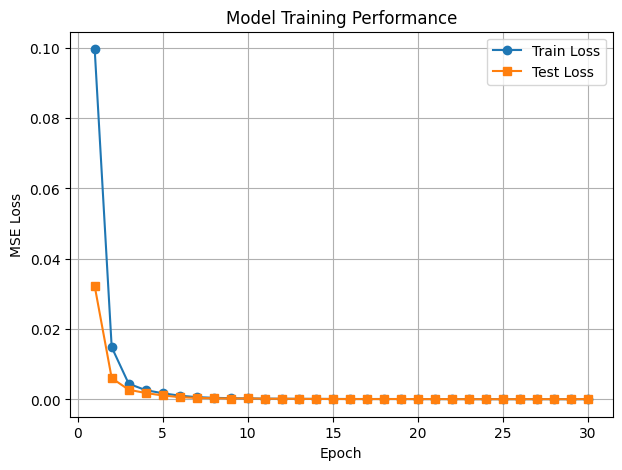

In [10]:
def full_protocol_demo():
    """
    1) Train the NN to learn mapping from (Wigner, eps) => (eta, gamma).
    2) Suppose we transmit a single state with some *unknown* channel (eta_true, gamma_true).
    3) We measure the output's Wigner + eps, feed it to the NN => (eta_est, gamma_est).
    4) Then we run ternary search over epsilon in [0, 0.3] to find eps_opt maximizing fidelity.
    5) Print results.

    This is a toy demonstration in code. In an actual experiment, steps 2-3
    correspond to physically generating the state, measuring it, etc.
    """
    # -------------------------
    # A) Train the model
    # -------------------------
    print("TRAINING THE MODEL...")
    model, train_losses, test_losses = train_model_with_eps(
        N_train=3000,
        N_test=300,
        q_pts=28,          # fewer points => faster
        range_q=(-4,4),
        range_p=(-4,4),
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1.0),
        db_range=(10.0, 15.0),
        n_epochs=30,
        batch_size=16,
        lr=1e-3,
        hidden_dim=64,
        Nphi=5,
        phi_clip=3.0
    )

    # Plot training curves
    plot_training_performance(train_losses, test_losses)


    return model

trained_model = full_protocol_demo()

In [128]:
# -------------------------
    # B) Simulate "unknown" channel for a single example
    #    e.g. (eta_true=0.8, gamma_true=0.4), db_input=12
    #    We pretend we measure the resulting Wigner and pass it to the NN
    # -------------------------
eta_true   = 0.8
gamma_true = 0.4
db_true    = 10.0  # we used GKP with ~10 dB
print("\n=== Simulating a single test example with ===")
print(f"    (eta_true={eta_true}, gamma_true={gamma_true}, db_true={db_true})")

# Generate Wigner data, feed to NN => estimated (eta_est, gamma_est)
eta_est, gamma_est = predict_single_example_with_eps(
    trained_model,
    eta_true   = eta_true,
    gamma_true = gamma_true,
    db_val     = db_true,
    q_pts      = 28,
    range_q    = (-4,4),
    range_p    = (-4,4),
    Nphi       = 5,
    phi_clip   = 3.0
)

print(f"NN predicted: (eta_est={eta_est:.3f}, gamma_est={gamma_est:.3f})")




=== Simulating a single test example with ===
    (eta_true=0.8, gamma_true=0.4, db_true=10.0)
NN predicted: (eta_est=0.792, gamma_est=0.389)


In [131]:
alpha_val = 1.0
beta_val  = 2

eps_min = 0.0
eps_max = 0.5

eps_opt, O_opt = ternary_search_code_fidelity(
    eta_est   = eta_est,
    gamma_est = gamma_est,
    alpha     = alpha_val,
    beta      = beta_val,
    eps_min   = eps_min,
    eps_max   = eps_max,
    tolerance = 1e-3,
    q_pts     = 28,
    range_q   = (-4,4),
    range_p   = (-4,4),
    backend   = "bosonic",
    Nphi      = 5,
    phi_clip  = 3.0
)

print(f"\n[CODE FIDELITY + Resource Penalty]")
print(f"  alpha={alpha_val}, beta={beta_val}")
print(f"  => eps_opt={eps_opt:.4f}, O_opt={O_opt:.4f}")

# Evaluate separate fidelity terms at eps_opt:
F00_opt = compute_fidelity_ij(eps_opt, "0","0", eta_est, gamma_est, q_pts=28)
F11_opt = compute_fidelity_ij(eps_opt, "1","1", eta_est, gamma_est, q_pts=28)
F01_opt = compute_fidelity_ij(eps_opt, "0","1", eta_est, gamma_est, q_pts=28)
F10_opt = compute_fidelity_ij(eps_opt, "1","0", eta_est, gamma_est, q_pts=28)

rc = resource_cost(eps_opt)
print(f"  F00={F00_opt:.4f}, F11={F11_opt:.4f}, F01={F01_opt:.4f}, F10={F10_opt:.4f}")
print(f"  Resource(dB) at eps_opt={rc:.4f} dB (penalty)")



[CODE FIDELITY + Resource Penalty]
  alpha=1.0, beta=2
  => eps_opt=0.4996, O_opt=-6.6159
  F00=0.4618, F11=0.2836, F01=0.1454, F10=0.1326
  Resource(dB) at eps_opt=3.3553 dB (penalty)
